<a href="https://www.kaggle.com/code/macmyller/pdi-project?scriptVersionId=202379804" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Imports

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

# Utils

In [2]:
# Setting up file paths
train_path = '/kaggle/input/kermany2018/OCT2017 /train'
test_path = '/kaggle/input/kermany2018/OCT2017 /test'
val_path = '/kaggle/input/kermany2018/OCT2017 /val'

In [3]:
categories = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
num_classes = len(categories) 
image_size = (128, 128)
batch_size = 84

# Exploratory Analysis

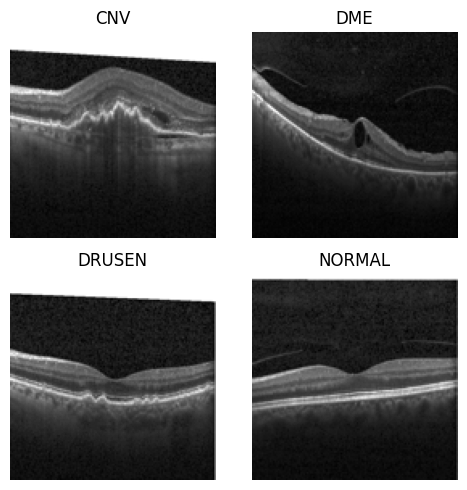

In [4]:
from PIL import Image

image_files = {
    'CNV': f'{val_path}/CNV/CNV-6294785-1.jpeg',
    'DME': f'{val_path}/DME/DME-9583225-1.jpeg',
    'DRUSEN': f'{val_path}/DRUSEN/DRUSEN-9800172-2.jpeg',
    'NORMAL': f'{val_path}/NORMAL/NORMAL-4872585-1.jpeg'
}

images = {cls: Image.open(img_path).resize(image_size) for cls, img_path in image_files.items()}
fig, axes = plt.subplots(2, 2, figsize=(5, 5))
for ax, (cls, img) in zip(axes.flatten(), images.items()):
    ax.set_title(cls)
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.tight_layout() 
plt.show()


In [5]:
# EDA: Count number of images per category in each set
def count_images_in_directory(directory):
    category_count = {}
    for category in categories:
        category_path = os.path.join(directory, category)
        category_count[category] = len(os.listdir(category_path))
    return category_count


train_distribution, test_distribution, val_distribution = \
%time count_images_in_directory(train_path), count_images_in_directory(test_path), count_images_in_directory(val_path)

CPU times: user 22.3 ms, sys: 39.6 ms, total: 61.9 ms
Wall time: 1.76 s


In [6]:
df_distribution = pd.DataFrame({
    "Train":train_distribution, 
    "Test":test_distribution, 
    "Validation":val_distribution
})

df_distribution.loc["Total"] = df_distribution.sum(axis=0)
df_distribution["Total"] = df_distribution.sum(axis=1)

df_distribution.T

,CNV,DME,DRUSEN,NORMAL,Total
Train,37205,11348,8616,26315,83484
Test,242,242,242,242,968
Validation,8,8,8,8,32
Total,37455,11598,8866,26565,84484


# Load Data (torch)

In [7]:
data_directory = train_path # No artigo, o autor utiliza apenas o diretório de treino para fazer o split em treino, teste e validação

In [8]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split

# TODO: MODIFICAR PARA USAR AS MESMAS TRANSFORMAÇÕES PRESENTES NO ARTIGO
# Transformações do dataset
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Carregar o dataset
%time dataset = datasets.ImageFolder(root=data_directory, transform=transform)

CPU times: user 608 ms, sys: 791 ms, total: 1.4 s
Wall time: 1min 10s


In [9]:
import torch

use_cuda = torch.cuda.is_available()
device = "cuda" if use_cuda else "cpu"
device

'cuda'

In [10]:
# TODO: UTILIZAR PEQUENAS PROPORCOES DOS DADOS PARA TREINAR/TESTAR/AVALIAR 
# OS MODELOS ENQUANTO NÃO RODAMOS DEFINITIVAMENTE

# TODO: LEMBRAR DE MODIFICAR PARA OS DATASETS COM PROPORÇÕES IGUAIS
# AO DO ARTIGO QUANDO FOR RODAR DEIFINITIVAMENTE


Reproduzir datasets com a mesma distribuição entre as classes do artigo (consequentemente a mesma proporção)

In [11]:
# import math
from torch.utils.data import Subset

def split_dataset_by_class(dataset, desired_counts):
    """
    Divide um dataset em conjuntos de treinamento, teste e validação com base em quantidades desejadas para cada classe.

    Args:
        dataset: O dataset a ser dividido (assumindo que tenha .targets e .classes).
        desired_counts: Um dicionário contendo as quantidades desejadas para treinamento, teste e validação por classe.

    Returns:
        tuple: Um tuplo contendo os datasets de treinamento, teste e validação.
    """
    # Acessa os rótulos e o número de classes
    class_indices = {i: [] for i in range(len(dataset.classes))}
    
    # Armazena índices para cada classe
    for idx, label in enumerate(dataset.targets):
        class_indices[label].append(idx)

    # Gera os índices desejados para a amostragem
    train_indices, test_indices, val_indices = [], [], []

    # Para cada classe, pega os índices desejados para train, test e val
    for cls in range(len(dataset.classes)):
        # Treinamento
        train_size = min(desired_counts['train'][cls], len(class_indices[cls]))
        train_indices.extend(class_indices[cls][:train_size])
        
        # Teste
        test_size = min(desired_counts['test'][cls], len(class_indices[cls]) - train_size)
        test_indices.extend(class_indices[cls][train_size:train_size + test_size])
        
        # Validação
        val_size = min(desired_counts['val'][cls], len(class_indices[cls]) - train_size - test_size)
        val_indices.extend(class_indices[cls][train_size + test_size:train_size + test_size + val_size])

    # Criar subsets
    train_dataset = Subset(dataset, train_indices)
    test_dataset = Subset(dataset, test_indices)
    val_dataset = Subset(dataset, val_indices)

    return train_dataset, test_dataset, val_dataset


In [12]:
from torch.utils.data import Subset

print(f'Use cuda: {use_cuda}')

def get_desired_counts(scale=1):
    """Retorna as quantidades desejadas para cada dataset conforme o artigo.
    
    Parâmetros:
        scale (int): Fator de escala para ajustar as quantidades desejadas.
        
    Retorna:
        dict: Dicionário com as quantidades desejadas para treinamento, teste e validação.
    """
    base_counts = { # classes 0, 1, 2, 3 / 'CNV', 'DME', 'DRUSEN', 'NORMAL'
        'train': [33509, 10197, 7753, 23811],  # Quantidades para treinamento
        'test':  [2951, 936, 693, 2098],       # Quantidades para teste
        'val':   [745, 215, 170, 406]          # Quantidades para validação
    }

    return {key: [count // scale for count in value] for key, value in base_counts.items()}

# Usando a função para definir os counts
if use_cuda:
    desired_counts = get_desired_counts()  # Usa os valores originais
else:
    desired_counts = get_desired_counts(scale=10)  # Usa 1//20 dos valores

# Separando os datasets
train_dataset, test_dataset, val_dataset = split_dataset_by_class(dataset, desired_counts)

print(len(train_dataset), len(test_dataset), len(val_dataset))
print(desired_counts)

Use cuda: True
75270 6678 1536
{'train': [33509, 10197, 7753, 23811], 'test': [2951, 936, 693, 2098], 'val': [745, 215, 170, 406]}


In [13]:
# Cria DataLoaders
batch_size = 84  # Ajutar o tamanho de batch quando for propor melhorias em comparação ao artigo
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [14]:
from collections import Counter

print("Train distribution")
%time train_dataset_distribution = Counter(categories[label] for _, label in train_dataset)
print("Test distribution")
%time test_dataset_distribution = Counter(categories[label] for _, label in test_dataset)
print("Val distribution")
%time val_dataset_distribution = Counter(categories[label] for _, label in val_dataset)

Train distribution
CPU times: user 17min 33s, sys: 38.4 s, total: 18min 11s
Wall time: 12min 25s
Test distribution
CPU times: user 1min 35s, sys: 3.44 s, total: 1min 38s
Wall time: 1min 8s
Val distribution
CPU times: user 21.2 s, sys: 766 ms, total: 21.9 s
Wall time: 15.1 s


In [15]:
data = {
    'Training': train_dataset_distribution, 
    'Testing': test_dataset_distribution, 
    'Validation': val_dataset_distribution, 
}

df_distribution = pd.DataFrame(data)
df_distribution.loc["Total"] = df_distribution.sum()
df_distribution["Total"] = df_distribution.sum(axis=1)
df_distribution[["Total", "Training", "Testing", "Validation"]].T

,CNV,DME,DRUSEN,NORMAL,Total
Total,37205,11348,8616,26315,83484
Training,33509,10197,7753,23811,75270
Testing,2951,936,693,2098,6678
Validation,745,215,170,406,1536


# Preprocessing

Etapas para pré-processamento de dados:

1.
Leia arquivos do diretório.

2.
Aplique o redimensionamento de cada imagem para 150 × 150 pixels.

3.
Aplique a operação CentreCrop com dimensões finais de 128 × 128 pixels a cada imagem.

4.
Converta a imagem para o tipo de dados tensor para compatibilidade com o modelo.

5.
Normalize a imagem subtraindo a média de cada valor de pixel e dividindo o resultado pelo desvio padrão usando a transformação padrão.



In [16]:
# TODO: PREPROCESSAR AS IMAGENS

Etapas para aprimoramento de imagem:

1.
Leia arquivos do diretório.

2.
Aplique filtro de desfoque médio para suavizar.

3.
Converta para escala de cinza para operações futuras.

4.
Aplique CLAHE sobre a imagem para melhorar o contraste baixo.

5.
Limiar de imagem por limites de corte de limiar adequados.

6.
Remova ruídos e quebras adicionais na estrutura por meio de operação de morfologia.

7.
Extraia contornos da saída acima para extrair bordas da camada da retina (as outras técnicas de detecção de bordas não foram úteis, conforme discutido).

8.
Desenhe contornos na imagem original para permitir bordas e estruturas de camadas.

9.
Aplique outras transformações como na etapa anterior, incluindo redimensionamento, corte central e normalização.



In [17]:
# TODO: APRIMORAR AS IMAGENS

# Convolutional Neural Network Architectures

## Architectures used in the article (torch)

In [18]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Definindo a arquitetura da CNN
class CNN5(nn.Module):
    def __init__(self):
        super(CNN5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(1, 1))
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(1, 1))
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1, 1))
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=48, kernel_size=(1, 1))
        self.conv5 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=(1, 1))

        # Calcular o tamanho da saída da última camada convolucional
        self._to_linear = None
        self._initialize_weights()

    def _initialize_weights(self):
        # Cria uma entrada fictícia para calcular o tamanho da saída da camada convolucional
        x = torch.randn(1, 3, 128, 128)  # Um exemplo com batch size 1
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        self._to_linear = x.numel()  # Número total de elementos na saída

        # Definir as camadas totalmente conectadas
        self.fc1 = nn.Linear(self._to_linear, 1536)
        self.fc2 = nn.Linear(1536, 512)
        self.fc3 = nn.Linear(512, 4)
        # TODO: FALTA A CAMADA DE DROPOUT 40%
        # TODO: FALTA A CAMADA DE LOG-SOFTMAX
        # OUTPUT: LOG-SOFTMAX PROBABILITY (4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = x.view(x.size(0), -1)  # Achatar o tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)  # Saída logits

In [19]:
import torch 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hiperparâmetros
learning_rate = 0.001
epochs = 10 if use_cuda else 3

# Instanciando o modelo, critério de perda e otimizador
model = CNN5().to(device) 
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
import time
import torch.nn.functional as F
from tqdm import tqdm  # Importar tqdm para a barra de progresso

# Treinamento
model.train()

for epoch in range(epochs):
    start_time = time.time()  # Início do tempo
    running_loss = 0.0
    # Usando tqdm para acompanhar o progresso
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  # Zerar gradientes
        outputs = model(inputs)  # Forward pass
        loss = criterion(F.log_softmax(outputs, dim=1), labels)  # Calcular a perda
        loss.backward()  # Backward pass
        optimizer.step()  # Atualizar pesos
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)  # Cálculo da perda média
    elapsed_time = time.time() - start_time  # Cálculo do tempo decorrido
    
    # Impressão do resultado ao final da época
    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}, Time: {elapsed_time:.2f}s')


Epoch [1/10], Loss: 1.1746, Time: 374.07s


Epoch [2/10], Loss: 0.9660, Time: 373.45s


Epoch [3/10], Loss: 0.8765, Time: 374.20s


Epoch [4/10], Loss: 0.8291, Time: 373.07s


Epoch [5/10], Loss: 0.7854, Time: 375.43s


Epoch [6/10], Loss: 0.7447, Time: 376.59s


Epoch [7/10], Loss: 0.7086, Time: 377.47s


Epoch [8/10], Loss: 0.6778, Time: 382.74s


Epoch [9/10], Loss: 0.6533, Time: 377.63s


Epoch [10/10], Loss: 0.6259, Time: 380.14s


In [21]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm  # Importar tqdm para a barra de progresso

# Avaliação do modelo no conjunto de teste
model.eval()  # Coloca o modelo em modo de avaliação
all_preds = []
all_labels = []

# Barra de progresso para o loop de inferência no conjunto de teste
with torch.no_grad():  # Desabilitar o cálculo de gradiente para economizar memória
    for inputs, labels in tqdm(test_loader, desc="Test Progress", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)  # Obter as previsões
        all_preds.extend(preds.cpu().numpy())  # Armazenar previsões
        all_labels.extend(labels.cpu().numpy())  # Armazenar rótulos verdadeiros

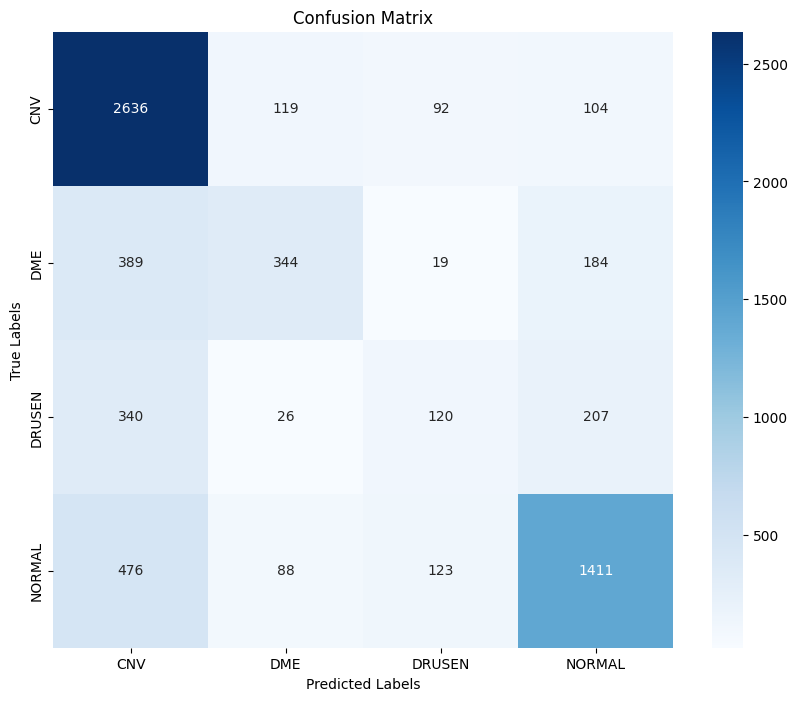

In [22]:
from sklearn.metrics import confusion_matrix
# Gerar a matriz de confusão
conf_matrix = confusion_matrix(all_labels, all_preds)

# Exibir a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
           xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.show()

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Calcular acurácia
accuracy = accuracy_score(all_labels, all_preds)
print(f"Acurácia: {accuracy:.4f}")

# Calcular precisão, recall e F1-score (para cada classe e média ponderada)
precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)
f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=1)
print(f"Precisão (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1-score (weighted): {f1:.4f}")


Acurácia: 0.6755
Precisão (weighted): 0.6546
Recall (weighted): 0.6755
F1-score (weighted): 0.6520


In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN5(nn.Module):
    def __init__(self):
        super(CNN5, self).__init__()
        
        # Camada convolucional 1 (Entrada: 128x128x3, Saída: 128x128x16)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)  # 3 canais de entrada (RGB)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Reduz a dimensão pela metade
        
        # Camada convolucional 2 (Entrada: 64x64x16, Saída: 64x64x32)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        # Camada convolucional 3-1 (Entrada: 32x32x32, Saída: 32x32x32)
        self.conv3_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        
        # Camada convolucional 3-2 (Entrada: 32x32x32, Saída: 32x32x48)
        self.conv3_2 = nn.Conv2d(in_channels=32, out_channels=48, kernel_size=3, padding=1)
        
        # Camada convolucional 4-1 (Entrada: 16x16x48, Saída: 16x16x48)
        self.conv4 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, padding=1)
        
        # Dropout para regularização
        self.dropout = nn.Dropout(p=0.4)
        
        # Fully connected layers (dense)
        # Linear camada após o flatten da saída convolucional
        self.fc1 = nn.Linear(48 * 8 * 8, 1536)  # A entrada da camada linear depende da saída da última conv/pooling
        self.fc2 = nn.Linear(1536, 512)
        self.fc3 = nn.Linear(512, 4)  # Saída final para 4 classes
        
    def forward(self, x):
        # Camada 1 - Conv1 + MaxPool
        x = self.pool(F.relu(self.conv1(x)))  # (128x128x16 -> 64x64x16)
        
        # Camada 2 - Conv2 + MaxPool
        x = self.pool(F.relu(self.conv2(x)))  # (64x64x32 -> 32x32x32)
        
        # Camada 3 - Conv3-1 + Conv3-2 + MaxPool
        x = F.relu(self.conv3_1(x))           # (32x32x32 -> 32x32x32)
        x = self.pool(F.relu(self.conv3_2(x)))  # (32x32x48 -> 16x16x48)
        
        # Camada 4 - Conv4-1 + MaxPool
        x = self.pool(F.relu(self.conv4(x)))  # (16x16x48 -> 8x8x48)
        
        # Flatten (achatar) os dados para a camada totalmente conectada (dense)
        x = x.view(-1, 48 * 8 * 8)  # (batch_size, 48*8*8)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))  # (48*8*8 -> 1536)
        x = F.relu(self.fc2(x))  # (1536 -> 512)
        
        # Aplicar dropout
        x = self.dropout(x)
        
        # Camada de saída - Log-Softmax
        x = F.log_softmax(self.fc3(x), dim=1)  # (512 -> 4)
        
        return x

from torchsummary import summary

# Instanciar o modelo e transferi-lo para o dispositivo desejado (CPU ou GPU)
model = CNN5()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Resumo da arquitetura
summary(model, input_size=(3, 128, 128))  # input_size deve ser (channels, height, width)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             448
         MaxPool2d-2           [-1, 16, 64, 64]               0
            Conv2d-3           [-1, 32, 64, 64]           4,640
         MaxPool2d-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,248
            Conv2d-6           [-1, 48, 32, 32]          13,872
         MaxPool2d-7           [-1, 48, 16, 16]               0
            Conv2d-8           [-1, 48, 16, 16]          20,784
         MaxPool2d-9             [-1, 48, 8, 8]               0
           Linear-10                 [-1, 1536]       4,720,128
           Linear-11                  [-1, 512]         786,944
          Dropout-12                  [-1, 512]               0
           Linear-13                    [-1, 4]           2,052
Total params: 5,558,116
Trainable param

In [25]:
import time
import torch.nn.functional as F
from tqdm import tqdm  # Importar tqdm para a barra de progresso

# Treinamento
model.train()


for epoch in range(epochs):
    start_time = time.time()  # Início do tempo
    running_loss = 0.0
    # Usando tqdm para acompanhar o progresso
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  # Zerar gradientes
        outputs = model(inputs)  # Forward pass
        loss = criterion(F.log_softmax(outputs, dim=1), labels)  # Calcular a perda
        loss.backward()  # Backward pass
        optimizer.step()  # Atualizar pesos
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)  # Cálculo da perda média
    elapsed_time = time.time() - start_time  # Cálculo do tempo decorrido
    
    # Impressão do resultado ao final da época
    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}, Time: {elapsed_time:.2f}s')


Epoch [1/10], Loss: 1.3864, Time: 386.92s


Epoch [2/10], Loss: 1.3864, Time: 387.61s


Epoch [3/10], Loss: 1.3864, Time: 388.96s


Epoch [4/10], Loss: 1.3864, Time: 390.65s


Epoch [5/10], Loss: 1.3864, Time: 387.34s


Epoch [6/10], Loss: 1.3864, Time: 391.80s


Epoch [7/10], Loss: 1.3864, Time: 388.12s


Epoch [8/10], Loss: 1.3864, Time: 386.26s


Epoch [9/10], Loss: 1.3864, Time: 389.21s


Epoch [10/10], Loss: 1.3864, Time: 389.82s


In [26]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm  # Importar tqdm para a barra de progresso

# Avaliação do modelo no conjunto de teste
model.eval()  # Coloca o modelo em modo de avaliação
all_preds = []
all_labels = []

# Barra de progresso para o loop de inferência no conjunto de teste
with torch.no_grad():  # Desabilitar o cálculo de gradiente para economizar memória
    for inputs, labels in tqdm(test_loader, desc="Test Progress", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)  # Obter as previsões
        all_preds.extend(preds.cpu().numpy())  # Armazenar previsões
        all_labels.extend(labels.cpu().numpy())  # Armazenar rótulos verdadeiros

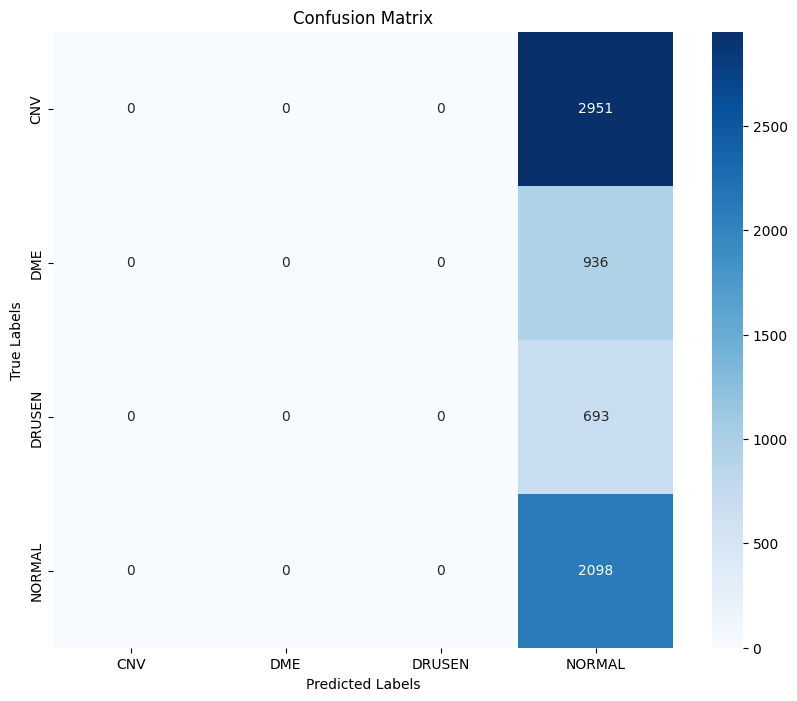

In [27]:
from sklearn.metrics import confusion_matrix
# Gerar a matriz de confusão
conf_matrix = confusion_matrix(all_labels, all_preds)

# Exibir a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
           xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.show()

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Calcular acurácia
accuracy = accuracy_score(all_labels, all_preds)
print(f"Acurácia: {accuracy:.4f}")

# Calcular precisão, recall e F1-score (para cada classe e média ponderada)
precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)
f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=1)
print(f"Precisão (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1-score (weighted): {f1:.4f}")


Acurácia: 0.3142
Precisão (weighted): 0.7845
Recall (weighted): 0.3142
F1-score (weighted): 0.1502
